# CIFAR 10 ConvNet model

### Preprocessing

In [36]:
%tensorflow_version 2.0 # Set tf2.0 version in Google Colab
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
import os
import datetime
import time
import tensorboard
%load_ext tensorboard


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("Tensorflow version: ",tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0 # Set tf2.0 version in Google Colab`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Tensorflow version:  2.1.0


# Training model with model.fit method

### callbacks

In [0]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler

logdir = 'logs/hparms'
chekpoints_dir = os.path.join('chekpoints', "ckpt_{epoch}")
batch_size = 250 # for having the rest to zero (50000 % 125 = 0)

# plot two separable plots of loss/accuracy model 
def history_model(history):
    plt.subplot(121)
    #rcParams['figure.figsize'] = 13, 7
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('ResNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.ylim([0.0,1.0])
    plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('ResNet loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.ylim([0.0,3.0])
    plt.legend(['train_loss', 'val_loss'])

    plt.show()

def lr_schedule(epoch: int):
    lr = 0.01
    if epoch > 180 :
        lr = 0.0001
    elif epoch > 90 :
        lr = 0.001
    return lr 

lrScheduler = LearningRateScheduler(lr_schedule)
# defining the callbacks
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1, update_freq='epoch', profile_batch = 100000000)  # log metrics
#Keras_callback =   # log hparams
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Save model after every 3 epochs (150000 / 50000)
checkpoint_callback = ModelCheckpoint(filepath = chekpoints_dir, save_freq=150000, monitor='val_loss',save_best_only=True, verbose = 1)

class TrainCallback(Callback):

    def __init__(self, x_train, y_train):
        super().__init__()
        self.x_train = x_train
        self.y_train = y_train
    
    def on_epoch_begin(self, epoch, logs=None):
        print("<-----------------------------------------------       EPOCH {}     ----------------------------------------------->".format(epoch+1))
        
    def on_epoch_end(self, epoch, logs=None):
        (loss, acc) = self.model.evaluate(self.x_train, self.y_train, batch_size = 4096, verbose=0, callbacks=[checkpoint_callback])
        print(f"Real Loss on train : {loss}")
        print(f"Real Acc on train : {acc}")
    
    def on_test_begin(self, epoch, logs=None):
        print("\nCalculating the real train loss/accuracy ...")
    

### Define the model

### CNN with 2 blocks of conv2D-Maxpool2D

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 2s 44us/sample - loss: 1.6236 - accuracy: 0.4068 - val_loss: 1.3555 - val_accuracy: 0.5096
Epoch 2/200
50000/50000 [==============================] - 2s 36us/sample - loss: 1.2376 - accuracy: 0.5603 - val_loss: 1.1432 - val_accuracy: 0.5942
Epoch 3/200
50000/50000 [==============================] - 2s 36us/sample - loss: 1.0822 - accuracy: 0.6190 - val_loss: 1.0300 - val_accuracy: 0.6330
Epoch 4/200
50000/50000 [==============================] - 2s 36us/sample - loss: 0.9659 - accuracy: 0.6616 - val_loss: 0.9673 - val_accuracy: 0.6623
Epoch 5/200
50000/50000 [==============================] - 2s 36us/sample - loss: 0.8881 - accuracy: 0.6903 - val_loss: 0.9212 - val_accuracy: 0.6779
Epoch 6/200
50000/50000 [==============================] - 2s 36us/sample - loss: 0.8270 - accuracy: 0.7124 - val_loss: 0.8994 - val_accuracy: 0.6873
Epoch 7/200
50000/50000 [=========================

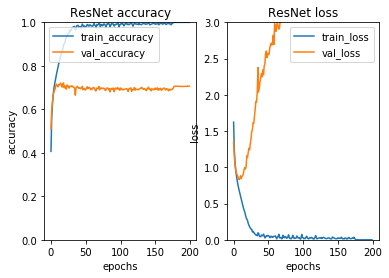

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def conv_model(dropout_rate = 0.0):
    
    dropout_rate = dropout_rate
    
    input = Input((32, 32, 3), name='input')
    
    conv_1 = Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_1')(input)
    pool_1 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_1')(conv_1)
    
    conv_2 = Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_2')(conv_2)
    
    flatten = Flatten(name='flatten')(pool_2)
    
    fc_1 = Dense(120, activation='relu', name='fc_1')(flatten)
    fc_2 = Dense(80, activation='relu', name='fc_2')(fc_1)
    
    output = Dense(10, activation='softmax', name='output')(fc_2)
    model = Model(input, output)
    
    plot_model(model, 'CNN.png')
    
    model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    
    hist = model.fit(x_train, y_train , epochs=200,
                     batch_size=256,
                     validation_data=(x_test, y_test))
    
    history_model(hist.history)

conv_model()

### Complexifying our model with 6 blocks of conv2D - MaxPool2D

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 3s 59us/sample - loss: 1.8290 - accuracy: 0.2983 - val_loss: 1.5254 - val_accuracy: 0.4186
Epoch 2/200
50000/50000 [==============================] - 2s 47us/sample - loss: 1.4158 - accuracy: 0.4695 - val_loss: 1.2635 - val_accuracy: 0.5310
Epoch 3/200
50000/50000 [==============================] - 2s 47us/sample - loss: 1.2054 - accuracy: 0.5600 - val_loss: 1.1382 - val_accuracy: 0.5893
Epoch 4/200
50000/50000 [==============================] - 2s 47us/sample - loss: 1.0590 - accuracy: 0.6150 - val_loss: 1.0583 - val_accuracy: 0.6188
Epoch 5/200
50000/50000 [==============================] - 2s 47us/sample - loss: 0.9412 - accuracy: 0.6605 - val_loss: 0.9825 - val_accuracy: 0.6499
Epoch 6/200
50000/50000 [==============================] - 2s 48us/sample - loss: 0.8480 - accuracy: 0.6975 - val_loss: 0.8870 - val_accuracy: 0.6897
Epoch 7/200
50000/50000 [=========================

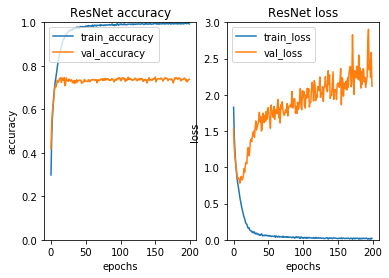

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def conv_model(dropout_rate = 0.0):
    
    dropout_rate = dropout_rate
    
    input = Input((32, 32, 3), name='input')
    
    conv_1 = Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_1')(input)
    pool_1 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_1')(conv_1)
    
    conv_2 = Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_2')(conv_2)

    conv_3 = Conv2D(96, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_3')(conv_3)

    conv_4 = Conv2D(96, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_4')(conv_4)

    conv_5 = Conv2D(96, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_5')(pool_4)
    pool_5 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_5')(conv_5)

    conv_6 = Conv2D(96, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_6')(pool_5)
    pool_6 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_6')(conv_6)
    
    flatten = Flatten(name='flatten')(pool_6)
    
    fc_1 = Dense(120, activation='relu', name='fc_1')(flatten)
    fc_2 = Dense(80, activation='relu', name='fc_2')(fc_1)
    
    output = Dense(10, activation='softmax', name='output')(fc_2)
    model = Model(input, output)
    
    plot_model(model, 'CNN_2.png')
    
    model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    
    hist = model.fit(x_train, y_train , epochs=200,
                     batch_size=256,
                     validation_data=(x_test, y_test))
    
    history_model(hist.history)

conv_model()

### Adding Dropout

#### dropout = 0.2

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 3s 68us/sample - loss: 2.0030 - accuracy: 0.2295 - val_loss: 1.6973 - val_accuracy: 0.3715
Epoch 2/200
50000/50000 [==============================] - 2s 49us/sample - loss: 1.5791 - accuracy: 0.4094 - val_loss: 1.4270 - val_accuracy: 0.4752
Epoch 3/200
50000/50000 [==============================] - 2s 49us/sample - loss: 1.3609 - accuracy: 0.5021 - val_loss: 1.1723 - val_accuracy: 0.5843
Epoch 4/200
50000/50000 [==============================] - 2s 49us/sample - loss: 1.2146 - accuracy: 0.5641 - val_loss: 1.0608 - val_accuracy: 0.6183
Epoch 5/200
50000/50000 [==============================] - 2s 49us/sample - loss: 1.1262 - accuracy: 0.5969 - val_loss: 0.9675 - val_accuracy: 0.6597
Epoch 6/200
50000/50000 [==============================] - 2s 49us/sample - loss: 1.0650 - accuracy: 0.6228 - val_loss: 0.9616 - val_accuracy: 0.6663
Epoch 7/200
50000/50000 [=========================

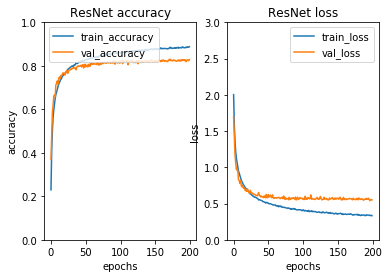

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def conv_model(dropout_rate = 0.0, epochs= epochs):
    
    dropout_rate = dropout_rate
    
    input = Input((32, 32, 3), name='input')
    
    conv_1 = Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_1')(input)
    pool_1 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_1')(conv_1)
    dropout_1 = Dropout(dropout_rate, name='dropout_1')(pool_1)
    
    conv_2 = Conv2D(64, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_2')(dropout_1)
    pool_2 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_2')(conv_2)
    dropout_2 = Dropout(dropout_rate, name='dropout_2')(pool_2)

    conv_3 = Conv2D(96, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_3')(dropout_2)
    pool_3 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_3')(conv_3)
    dropout_3 = Dropout(dropout_rate, name='dropout_3')(pool_3)

    conv_4 = Conv2D(96, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_4')(dropout_3)
    pool_4 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_4')(conv_4)
    dropout_4 = Dropout(dropout_rate, name='dropout_4')(pool_4)

    conv_5 = Conv2D(96, (3,3), strides=(1, 1), padding='same', activation='relu', name='conv_5')(dropout_4)
    pool_5 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_5')(conv_5)
    dropout_5 = Dropout(dropout_rate, name='dropout_5')(pool_5)
    
    flatten = Flatten(name='flatten')(dropout_5)
    
    fc_1 = Dense(120, activation='relu', name='fc_1')(flatten)
    dropout_6 = Dropout(dropout_rate, name='dropout_6')(fc_1)
    fc_2 = Dense(80, activation='relu', name='fc_2')(dropout_6)
    dropout_7 = Dropout(dropout_rate, name='dropout_7')(fc_2)
    
    output = Dense(10, activation='softmax', name='output')(dropout_7)
    model = Model(input, output)
    
    plot_model(model, 'CNN_2.png')
    
    model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    
    hist = model.fit(x_train, y_train , epochs=epochs,
                     batch_size=256,
                     validation_data=(x_test, y_test))
    
    history_model(hist.history)

conv_model(0.2)

#### dropout = 0.6

Train on 50000 samples, validate on 10000 samples
Epoch 1/400
50000/50000 [==============================] - 3s 64us/sample - loss: 2.2818 - accuracy: 0.1300 - val_loss: 2.2970 - val_accuracy: 0.1059
Epoch 2/400
50000/50000 [==============================] - 2s 49us/sample - loss: 2.1180 - accuracy: 0.1794 - val_loss: 2.1005 - val_accuracy: 0.1701
Epoch 3/400
50000/50000 [==============================] - 2s 49us/sample - loss: 1.9919 - accuracy: 0.1859 - val_loss: 2.0778 - val_accuracy: 0.1835
Epoch 4/400
50000/50000 [==============================] - 2s 48us/sample - loss: 1.9519 - accuracy: 0.1976 - val_loss: 2.3297 - val_accuracy: 0.1362
Epoch 5/400
50000/50000 [==============================] - 2s 49us/sample - loss: 1.9283 - accuracy: 0.2026 - val_loss: 2.1175 - val_accuracy: 0.1607
Epoch 6/400
50000/50000 [==============================] - 2s 48us/sample - loss: 1.9095 - accuracy: 0.2058 - val_loss: 1.9994 - val_accuracy: 0.1821
Epoch 7/400
50000/50000 [=========================

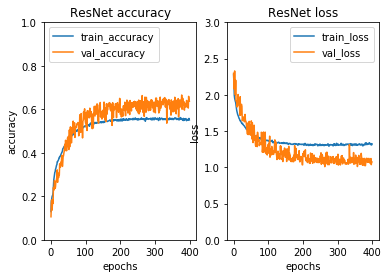

In [0]:
conv_model(0.6, 400)

### Adding L2 regularization

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 3s 66us/sample - loss: 2.0348 - accuracy: 0.2201 - val_loss: 1.7154 - val_accuracy: 0.3590
Epoch 2/200
50000/50000 [==============================] - 2s 49us/sample - loss: 1.5988 - accuracy: 0.4028 - val_loss: 1.3848 - val_accuracy: 0.4907
Epoch 3/200
50000/50000 [==============================] - 2s 49us/sample - loss: 1.3527 - accuracy: 0.5076 - val_loss: 1.2293 - val_accuracy: 0.5557
Epoch 4/200
50000/50000 [==============================] - 2s 49us/sample - loss: 1.2305 - accuracy: 0.5593 - val_loss: 1.0758 - val_accuracy: 0.6195
Epoch 5/200
50000/50000 [==============================] - 2s 49us/sample - loss: 1.1452 - accuracy: 0.5964 - val_loss: 1.0769 - val_accuracy: 0.6241
Epoch 6/200
50000/50000 [==============================] - 2s 49us/sample - loss: 1.0746 - accuracy: 0.6239 - val_loss: 0.9775 - val_accuracy: 0.6612
Epoch 7/200
50000/50000 [=========================

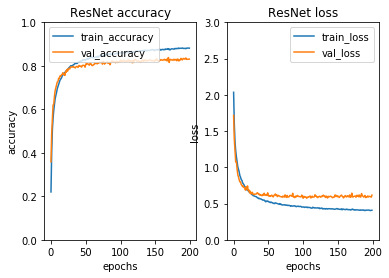

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def conv_model(dropout_rate = 0.0):
    
    dropout_rate = dropout_rate
    
    input = Input((32, 32, 3), name='input')
    
    conv_1 = Conv2D(64, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_1')(input)
    pool_1 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_1')(conv_1)
    dropout_1 = Dropout(dropout_rate, name='dropout_1')(pool_1)
    
    conv_2 = Conv2D(64, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_2')(dropout_1)
    pool_2 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_2')(conv_2)
    dropout_2 = Dropout(dropout_rate, name='dropout_2')(pool_2)

    conv_3 = Conv2D(96, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_3')(dropout_2)
    pool_3 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_3')(conv_3)
    dropout_3 = Dropout(dropout_rate, name='dropout_3')(pool_3)

    conv_4 = Conv2D(96, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_4')(dropout_3)
    pool_4 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_4')(conv_4)
    dropout_4 = Dropout(dropout_rate, name='dropout_4')(pool_4)

    conv_5 = Conv2D(96, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_5')(dropout_4)
    pool_5 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_5')(conv_5)
    dropout_5 = Dropout(dropout_rate, name='dropout_5')(pool_5)
    
    flatten = Flatten(name='flatten')(dropout_5)
    
    fc_1 = Dense(120, activation='relu', name='fc_1')(flatten)
    dropout_6 = Dropout(dropout_rate, name='dropout_6')(fc_1)
    fc_2 = Dense(80, activation='relu', name='fc_2')(dropout_6)
    dropout_7 = Dropout(dropout_rate, name='dropout_7')(fc_2)
    
    output = Dense(10, activation='softmax', name='output')(dropout_7)
    model = Model(input, output)
    
    plot_model(model, 'CNN_2.png')
    
    model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    
    hist = model.fit(x_train, y_train , epochs=200,
                     batch_size=256,
                     validation_data=(x_test, y_test))
    
    history_model(hist.history)

conv_model(0.2)

L2 + batchnorm

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 4s 71us/sample - loss: 1.8098 - accuracy: 0.3303 - val_loss: 2.3104 - val_accuracy: 0.1465
Epoch 2/200
50000/50000 [==============================] - 3s 52us/sample - loss: 1.4132 - accuracy: 0.4860 - val_loss: 1.5149 - val_accuracy: 0.4535
Epoch 3/200
50000/50000 [==============================] - 3s 52us/sample - loss: 1.2230 - accuracy: 0.5624 - val_loss: 1.1193 - val_accuracy: 0.6008
Epoch 4/200
50000/50000 [==============================] - 3s 53us/sample - loss: 1.0964 - accuracy: 0.6110 - val_loss: 0.9547 - val_accuracy: 0.6619
Epoch 5/200
50000/50000 [==============================] - 3s 54us/sample - loss: 1.0014 - accuracy: 0.6478 - val_loss: 0.8636 - val_accuracy: 0.6925
Epoch 6/200
50000/50000 [==============================] - 3s 53us/sample - loss: 0.9379 - accuracy: 0.6722 - val_loss: 0.8374 - val_accuracy: 0.7092
Epoch 7/200
50000/50000 [=========================

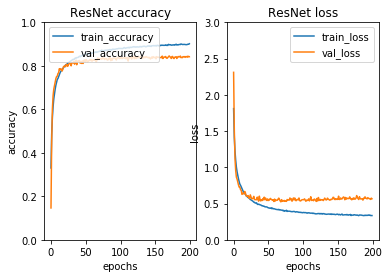

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def conv_model(dropout_rate = 0.0):
    
    dropout_rate = dropout_rate
    
    input = Input((32, 32, 3), name='input')

    batch_norm = BatchNormalization(name="batch_norm")(input)
    
    conv_1 = Conv2D(64, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_1')(batch_norm)
    pool_1 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_1')(conv_1)
    dropout_1 = Dropout(dropout_rate, name='dropout_1')(pool_1)
    
    conv_2 = Conv2D(64, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_2')(dropout_1)
    pool_2 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_2')(conv_2)
    dropout_2 = Dropout(dropout_rate, name='dropout_2')(pool_2)

    conv_3 = Conv2D(96, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_3')(dropout_2)
    pool_3 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_3')(conv_3)
    dropout_3 = Dropout(dropout_rate, name='dropout_3')(pool_3)

    conv_4 = Conv2D(96, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_4')(dropout_3)
    pool_4 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_4')(conv_4)
    dropout_4 = Dropout(dropout_rate, name='dropout_4')(pool_4)

    conv_5 = Conv2D(96, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_5')(dropout_4)
    pool_5 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_5')(conv_5)
    dropout_5 = Dropout(dropout_rate, name='dropout_5')(pool_5)
    
    flatten = Flatten(name='flatten')(dropout_4)
    batch_norm_2 = BatchNormalization(name="batch_norm_2")(flatten)

    fc_1 = Dense(120, activation='relu', name='fc_1')(batch_norm_2)
    dropout_6 = Dropout(dropout_rate, name='dropout_6')(fc_1)
    fc_2 = Dense(80, activation='relu', name='fc_2')(dropout_6)
    dropout_7 = Dropout(dropout_rate, name='dropout_7')(fc_2)
    
    output = Dense(10, activation='softmax', name='output')(dropout_7)
    model = Model(input, output)
    
    plot_model(model, 'CNN_2.png')
    
    model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    
    hist = model.fit(x_train, y_train , epochs=200,
                     batch_size=256,
                     validation_data=(x_test, y_test))
    
    history_model(hist.history)

conv_model(0.2)

### Adding Data augmentation

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def conv_model(dropout_rate = 0.0):
    
    dropout_rate = dropout_rate
    
    input = Input((32, 32, 3), name='input')

    batch_norm = BatchNormalization(name="batch_norm")(input)
    
    conv_1 = Conv2D(32, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_1')(batch_norm)
    pool_1 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_1')(conv_1)
    dropout_1 = Dropout(dropout_rate, name='dropout_1')(pool_1)
    
    conv_2 = Conv2D(32, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_2')(dropout_1)
    pool_2 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_2')(conv_2)
    dropout_2 = Dropout(dropout_rate, name='dropout_2')(pool_2)

    conv_3 = Conv2D(64, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_3')(dropout_2)
    pool_3 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_3')(conv_3)
    dropout_3 = Dropout(dropout_rate, name='dropout_3')(pool_3)

    conv_4 = Conv2D(64, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_4')(dropout_3)
    pool_4 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_4')(conv_4)
    dropout_4 = Dropout(dropout_rate, name='dropout_4')(pool_4)

    conv_5 = Conv2D(96, (3,3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.00001), activation='relu', name='conv_5')(dropout_4)
    pool_5 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_5')(conv_5)
    dropout_5 = Dropout(dropout_rate, name='dropout_5')(pool_5)
    
    flatten = Flatten(name='flatten')(dropout_4)
    batch_norm_2 = BatchNormalization(name="batch_norm_2")(flatten)

    fc_1 = Dense(120, activation='relu', name='fc_1')(batch_norm_2)
    batch_norm_3 = BatchNormalization(name="batch_norm_3")(fc_1)
    dropout_6 = Dropout(dropout_rate, name='dropout_6')(batch_norm_3)
    fc_2 = Dense(80, activation='relu', name='fc_2')(dropout_6)
    batch_norm_4 = BatchNormalization(name="batch_norm_4")(fc_2)
    dropout_7 = Dropout(dropout_rate, name='dropout_7')(batch_norm_4)
    
    output = Dense(10, activation='softmax', name='output')(dropout_7)
    model = Model(input, output)
    
    plot_model(model, 'CNN_2.png')
    
    model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    #data augmentation
    datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        )
  
    batch_size = 128
    train_datagen = datagen.flow(x_train, y_train, batch_size=batch_size)
    steps = int(x_train.shape[0] / batch_size)

    hist = model.fit_generator(train_datagen, 
                               steps_per_epoch=steps,
                               epochs=150,
                               validation_data=(x_test, y_test))

	  #history = model.fit_generator( epochs=200, validation_data=(testX, testY), verbose=0)


    history_model(hist.history)

    return model

model = conv_model(0.1)

### Saving the model

In [0]:
model.save("CNN.h5")

### let's run some tests

In [0]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

img_row, img_height, img_depth = 32,32,3
color = True
scale = 8


#model = model.load_weights(tf.train.latest_checkpoint('/content/chekpoints'))
eval_loss, eval_acc = model.evaluate(x_test, y_test)
print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

def draw_test(name, res, input_im, scale, img_row, img_height):
    BLACK = [0,0,0]
    res = int(res)
    if res == 0:
        pred = "airplane"
    if res == 1:
        pred = "automobile"
    if res == 2:
        pred = "bird"
    if res == 3:
        pred = "cat"
    if res == 4:
        pred = "deer"
    if res == 5:
        pred = "dog"
    if res == 6:
        pred = "frog"
    if res == 7:
        pred = "horse"
    if res == 8:
        pred = "ship"
    if res == 9:
        pred = "truck"
        
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, imageL.shape[0]*2 ,cv2.BORDER_CONSTANT,value=BLACK)
    if color == False:
        expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)
    cv2.putText(expanded_image, str(pred), (300, 80) , cv2.FONT_HERSHEY_COMPLEX_SMALL,4, (0,255,255), 2)
    cv2_imshow( expanded_image)
    #cv2.imshow(name, expanded_image)


for i in range(0,10):
    rand = np.random.randint(0,len(x_test))
    input_im = x_test[rand]
    imageL = cv2.resize(input_im, None, fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC) 
    input_im = input_im.reshape(1,img_row, img_height, img_depth) 
    
    ## Get Prediction
    res = model.predict(input_im)
    res = np.where(res[0] == max(res[0]))[0][0]
    draw_test("Prediction", res, imageL, scale, img_row, img_height) 
    cv2.waitKey(0)

cv2.destroyAllWindows()